In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
np.set_printoptions(precision=3, suppress=True,formatter={'float': '{: 0.3f}'.format})

## Matriz de Confusão

A matriz de confusão é uma matriz quadrada em que cada dimensão são os números possívels de categorias (classes). Usando a convenção utilizada no skicit-learn, as linhas são as classes reais oriundas do dataset e as colunas são as classes preditas pelo classificador. Cada elemento da matriz é o número de ocorrências que ocorreram com uma amostra que é da classe i e foi predita na classe j. Podemos dizer que a matriz de confusão é um histograma bidimensional associado à classe real e à classe predita.

![fig. matriz de confusão](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/matriz_confusao.png)

## NumPy implementation of Confusion Matrix

In [ ]:
# Slow implementation using the definition of a 2D histogram
def build_confusion_matrix_slow(y_true, y_pred):
    n_classes = y_true.max() + 1
    cm = np.zeros((n_classes,n_classes), dtype=np.int)
    for i,j in zip(y_true,y_pred):
        cm[i,j] += 1
    return cm

In [ ]:
# Faster implementation using np.bincount (1D histogram)
# need to convert the 2D matrix to 1D vector
def build_confusion_matrix(y_true, y_pred):
    n_classes = y_true.max() + 1
    cm = np.bincount(y_true * n_classes + y_pred)
    n_last = n_classes**2 - len(cm)
    if n_last:
        cm = np.concatenate((cm,np.zeros((n_last,),dtype=cm.dtype)))
    return cm.reshape(n_classes, n_classes)

## PyTorch implementation of Confusion Matrix

In [ ]:
# Slow implementation using the definition of a 2D histogram
def build_confusion_matrix_slow_torch(y_true, y_pred):
    n_classes = y_true.max() + 1
    cm = torch.zeros((n_classes,n_classes), dtype=torch.int)
    for i,j in zip(y_true,y_pred):
        cm[i,j] += 1
    return cm

In [ ]:
# Faster implementation using np.bincount (1D histogram)
# need to convert the 2D matrix to 1D vector
def build_confusion_matrix_torch(y_true, y_pred):
    n_classes = y_true.max() + 1
    cm = torch.bincount(y_true * n_classes + y_pred)
    n_last = n_classes**2 - len(cm)
    if n_last:
        cm = torch.cat((cm,torch.zeros((n_last,),dtype=cm.dtype)))
    return cm.reshape(n_classes, n_classes)

## Precision, Recall and F1

Precision of class c is the number of times the prediction is correct divided by all predictions of class c. Using the confusion matrix, it is the element (c,c) divided by all predictions of column c.

Recall of class c is the number of times the prediction is correct divided by all samples of classe c. Using the confusion matrix, it is the element (c,c) divided by all elements of line c.

F1 is the harmonic mean of precision and recall.

Precision ($P$) is defined as the number of true positives ($T_p$)
over the number of true positives plus the number of false positives
($F_p$).

$P = \frac{T_p}{T_p+F_p}$

Recall ($R$) is defined as the number of true positives ($T_p$)
over the number of true positives plus the number of false negatives
($F_n$).

$R = \frac{T_p}{T_p + F_n}$

These quantities are also related to the ($F_1$) score, which is defined
as the harmonic mean of precision and recall.

$F1 = 2\frac{P \times R}{P+R}$


In [ ]:
def precision_recall_f1(confusion_matrix):
    # dataset: axis 1
    # prediction: axis 0
    eps = np.finfo(np.float32).eps
    ds_sum = confusion_matrix.sum(axis=1)
    pred_sum = confusion_matrix.sum(axis=0)
    acc = confusion_matrix.diagonal()
    precision = acc/pred_sum
    recall = acc/ds_sum
    f1 = 2*(precision*recall)/(precision+recall + eps)
    return precision,recall,f1

[source](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin)

Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

To illustrate why, take for example precision $Pr=\frac{TP}{(TP+FP)}$. Let's imagine you have a One-vs-All (there is only one correct class output per example) multi-class classification system with four classes and the following numbers when tested:

- Class A: 1 TP and 1 FP
- Class B: 10 TP and 90 FP
- Class C: 1 TP and 1 FP
- Class D: 1 TP and 1 FP

You can see easily that $ 𝑃𝑟𝐴=𝑃𝑟𝐶=𝑃𝑟𝐷=0.5 $, whereas 𝑃𝑟𝐵=0.1.

A macro-average will then compute: $𝑃𝑟=\frac{0.5+0.1+0.5+0.5}{4}=0.4$

A micro-average will compute: $𝑃𝑟=\frac{1+10+1+1}{2+100+2+2}=0.123$

## Micro averaging, fazendo o cálculo com a soma dos TP, FN e FP

Micro averaging é igual a acurácia neste exemplo. Ele só será diferente da acurácia quando o problema é multi label, isto é, o número de exemplos não é igual a soma de todos os valores da matriz de confusão, pois o predict de um exemplo poderá dar mais de uma classe como resultado.

In [ ]:
def precision_recall_f1_micro(confusion_matrix):
    eps = np.finfo(np.float32).eps
    tp = confusion_matrix.diagonal()
    fn_sum = (confusion_matrix.sum(axis=1) - tp).sum()
    fp_sum = (confusion_matrix.sum(axis=0) - tp).sum()
    tp_sum = tp.sum()
    precision = tp_sum/(tp_sum + fp_sum)
    recall = tp_sum/(tp_sum + fn_sum)
    f1 = 2*(precision*recall)/(precision+recall + eps)
    return precision,recall,f1

## Macro averaging, é a média das métricas

In [ ]:
def precision_recall_f1_macro(confusion_matrix):
    p,r,f1 = precision_recall_f1(confusion_matrix)
    return p.mean(), r.mean(), f1.mean()

## Acurácia é o número de vezes que o classificador acertou sobre o total de amostras.

Pode ser calculado como a média dos acertos ou usando a matriz de confusão, como a soma dos elementos da diagonal sobre o número total de amostras.

In [ ]:
def accuracy(y_true,y_pred):
    return (y_true == y_pred).mean()

In [ ]:
def acc_from_cm(cm):
    return cm.diagonal().sum()/cm.sum()

## Testing: Build confusion matrix - NumPy

In [ ]:
y_true = np.array([0, 0, 0, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2])
y_pred = np.array([0, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2])
cm1 = build_confusion_matrix_slow(y_true, y_pred)
cm  = build_confusion_matrix(y_true, y_pred)
print('slow:\n',cm1)
print('cm:\n',cm)

slow:
 [[3 1 2]
 [1 1 1]
 [0 2 3]]
cm:
 [[3 1 2]
 [1 1 1]
 [0 2 3]]


## Testing Build confusion Matriz - PyTorch

In [ ]:
t_y_true = torch.tensor([0, 0, 0, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2])
t_y_pred = torch.tensor([0, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2])
t_cm1 = build_confusion_matrix_slow_torch(t_y_true, t_y_pred)
t_cm  = build_confusion_matrix_torch(t_y_true, t_y_pred)
print('slow:\n', t_cm1)
print('cm:\n', t_cm)

slow:
 tensor([[3, 1, 2],
        [1, 1, 1],
        [0, 2, 3]], dtype=torch.int32)
cm:
 tensor([[3, 1, 2],
        [1, 1, 1],
        [0, 2, 3]])


## Visualização da Matriz de Confusão com o Pandas e Seaborn

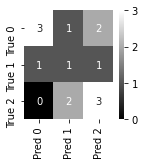

In [ ]:
df_cm = pd.DataFrame(cm, 
                     index = [i for i in ["True 0", "True 1", "True 2"]],
                     columns = [i for i in ["Pred 0", "Pred 1", "Pred 2"]])
plt.figure(figsize = (2,2))
sn.heatmap(df_cm, annot=True,cmap='gray');

In [ ]:
p, r, f1 = precision_recall_f1(cm)
print('precision:',p)
print('recal:    ',r)
print('f1:       ',f1)

precision: [ 0.750  0.250  0.500]
recal:     [ 0.500  0.333  0.600]
f1:        [ 0.600  0.286  0.545]


## Testando Macro averaging, é a média das métricas

In [ ]:
p_macro, r_macro, f1_macro = precision_recall_f1_macro(cm)
print('precision (macro): {:0.3f}'.format( p_macro))
print('recall    (macro): {:0.3f}'.format( r_macro))
print('f1        (macro): {:0.3f}'.format( f1_macro))


precision (macro): 0.500
recall    (macro): 0.478
f1        (macro): 0.477


## Micro averaging, usa o cálculo dos TPs, FNs e FPs

In [ ]:
p_micro, r_micro, f1_micro = precision_recall_f1_micro(cm)
print('precision (micro): {:0.3f}'.format( p_micro))
print('recall    (micro): {:0.3f}'.format( r_micro))
print('f1        (micro): {:0.3f}'.format( f1_micro))


precision (micro): 0.500
recall    (micro): 0.500
f1        (micro): 0.500


In [ ]:
acc = accuracy(y_true,y_pred)
acc

0.5

In [ ]:
acc = acc_from_cm(cm)
acc

0.5

## Comparando com Scikit-learn

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
print('precision:',precision_score(y_true,y_pred,average=None))
print('recal:    ',recall_score(y_true,y_pred,average=None))
print('f1:       ',f1_score(y_true, y_pred, average=None))

precision: [ 0.750  0.250  0.500]
recal:     [ 0.500  0.333  0.600]
f1:        [ 0.600  0.286  0.545]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.25      0.33      0.29         3
           2       0.50      0.60      0.55         5

    accuracy                           0.50        14
   macro avg       0.50      0.48      0.48        14
weighted avg       0.55      0.50      0.51        14



In [ ]:
precision_score(y_true,y_pred,average='micro'),recall_score(y_true,y_pred,average='micro'),f1_score(y_true,y_pred,average='micro')

(0.5, 0.5, 0.5)